In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [2]:
def log_likelihood(y_true, y_pred):
    """Calculate the log-likelihood for a Poisson model."""
    return np.sum(y_true * np.log(y_pred) - y_pred)

In [3]:
def deviance(y_true, y_pred):
    """Calculate the deviance for a Poisson model."""
    ll_est = log_likelihood(y_true, y_pred)
    y_true_nz = y_true[y_true != 0]
    ll_true = log_likelihood(y_true_nz, y_true_nz)
    return ll_true - ll_est

In [4]:
results_path = os.path.join(os.environ['HOME'], 'fits/monkey1.h5')

In [5]:
results = h5py.File(results_path, 'r')

In [6]:
glmnet = results['glmnet_poisson']
uoi_poisson_log = results['uoi_poisson_log']
uoi_poisson_aic = results['uoi_poisson_AIC']
uoi_poisson_bic = results['uoi_poisson_BIC']
uoi_fits = [uoi_poisson_log, uoi_poisson_aic, uoi_poisson_bic]

In [7]:
Y = results['glmnet_poisson/Y'][:]
n_folds = 10
n_neurons = Y.shape[1]

In [8]:
lls = [np.zeros((n_folds, n_neurons)) for fit in uoi_fits]
deviances = [np.zeros((n_folds, n_neurons)) for fit in uoi_fits]

In [9]:
for idx, fit in enumerate(uoi_fits):
    for fold in range(n_folds):
        train_idx = glmnet['train_folds/fold_' + str(fold)][:]
        test_idx = glmnet['test_folds/fold_' + str(fold)][:]

        Y_train = Y[train_idx, :]
        Y_test = Y[test_idx, :]

        for neuron in range(n_neurons):
            X_train = np.delete(Y_train, neuron, axis=1)
            y_train = Y_train[:, neuron]

            X_test = np.delete(Y_test, neuron, axis=1)
            y_test = Y_test[:, neuron]

            coupling_coefs = fit['coupling_coefs'][fold, neuron]
            intercept = np.log(
                np.mean(y_train) / np.mean(np.exp(np.dot(X_train, coupling_coefs)))
            )
            lls[idx][fold, neuron] = log_likelihood(y_test, np.exp(intercept + np.dot(X_test, coupling_coefs)))
            deviances[idx][fold, neuron] = deviance(y_test, np.exp(intercept + np.dot(X_test, coupling_coefs)))

In [5]:
results['glmnet_poisson/deviances_test']

<HDF5 dataset "deviances_test": shape (10, 106), type "<f8">

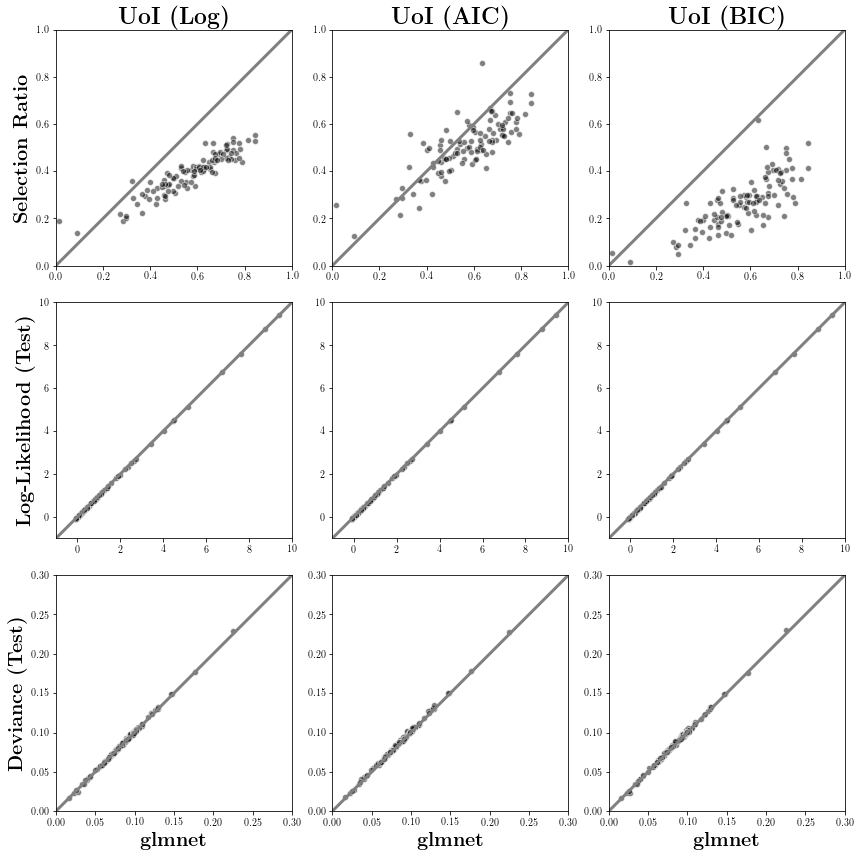

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx, ax in enumerate(axes[0]):
    ax.scatter(
        np.median(np.count_nonzero(glmnet['coupling_coefs'], axis=2), axis=0) / 105.,
        np.median(np.count_nonzero(uoi_fits[idx]['coupling_coefs'], axis=2), axis=0) / 105.,
        color='k',
        edgecolor='white',
        alpha=0.5
    )
    
    ax.plot([0, 1], [0, 1], color='gray', linewidth=3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    
for idx, ax in enumerate(axes[1]):
    ax.scatter(
        np.median(glmnet['test_lls'], axis=0) / Y.shape[0],
        np.median(lls[idx], axis=0) / Y.shape[0],
        color='k',
        edgecolor='white',
        alpha=0.5
    )
    
    ax.plot([-1, 10], [-1, 10], color='gray', linewidth=3)
    ax.set_xlim([-1, 10])
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect('equal')
    
for idx, ax in enumerate(axes[2]):
    ax.scatter(
        np.median(glmnet['deviances_test'], axis=0) / Y.shape[0],
        np.median(deviances[idx], axis=0) / Y.shape[0],
        color='k',
        edgecolor='white',
        alpha=0.5
    )
    
    ax.plot([0, 0.3], [0, 0.3], color='gray', linewidth=3)
    ax.set_xlim([0, 0.3])
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect('equal')

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Log-Likelihood (Test)}', fontsize=20)
axes[2, 0].set_ylabel(r'\textbf{Deviance (Test)}', fontsize=20)

axes[0, 0].set_title(r'\textbf{UoI (Log)}', fontsize=23)
axes[0, 1].set_title(r'\textbf{UoI (AIC)}', fontsize=23)
axes[0, 2].set_title(r'\textbf{UoI (BIC)}', fontsize=23)

axes[2, 0].set_xlabel(r'\textbf{glmnet}', fontsize=20)
axes[2, 1].set_xlabel(r'\textbf{glmnet}', fontsize=20)
axes[2, 2].set_xlabel(r'\textbf{glmnet}', fontsize=20)

plt.tight_layout()
plt.savefig('uoi_poisson_pvc11_monkey1_results.pdf', bbox_inches='tight')